In [1]:
import os
import numpy as np
from util.extract_topics import McapTimeWindowExtractor
from scipy.spatial.transform import Rotation
from typing import List, Dict, Optional

import cv2
import matplotlib.pyplot as plt


import copy

In [2]:
extractor = McapTimeWindowExtractor(
    mcap_path="dataset/huntington.mcap",
    camera_topic="/cam_sync/cam0/image_raw/compressed",
    lidar_topic="/ouster/points",
    imu_topic="/vectornav/imu_uncompensated",
    start_time=2.0,    # Start at x seconds
    duration=0.5        # Extract y seconds worth
)
extractor.extract()

Reading MCAP: dataset/huntington.mcap
Camera topic: /cam_sync/cam0/image_raw/compressed
LiDAR topic:  /ouster/points
IMU topic:    /vectornav/imu_uncompensated

Extracting time window:
  Start: +2.0s from bag start
  Duration: 0.5s


Extracting: 116msg [00:09, 12.61msg/s]


  Extraction complete:
  Camera frames: 10
  LiDAR scans:   5
  IMU samples:   101
  Actual time span: 0.44s


In [3]:
camera_frames_raw = extractor.camera_frames
lidar_scans_raw = extractor.lidar_scans
imu_measurements_raw = extractor.imu_measurements

In [4]:
# Deep copy to preserve raw data
camera_frames = copy.deepcopy(camera_frames_raw)
lidar_scans = copy.deepcopy(lidar_scans_raw)
imu_measurements = copy.deepcopy(imu_measurements_raw)


# Lidar points Densification outliers removal

In [5]:
print("LIDAR POINT CLOUD FILTERING")
print()

# Filter all LiDAR scans
for scan_idx, scan in enumerate(lidar_scans):
    points_raw = scan['points']
    
    # Step 1: Remove origin points (invalid measurements)
    distances = np.linalg.norm(points_raw, axis=1)
    mask_not_origin = distances > 0.1
    points = points_raw[mask_not_origin]
    
    # Step 2: Remove points beyond reasonable range
    distances_filtered = np.linalg.norm(points, axis=1)
    mask_range = distances_filtered < 100.0
    points = points[mask_range]
    
    # Step 3: Remove statistical outliers (>3σ from mean) per axis
    for axis in range(3):
        mean = np.mean(points[:, axis])
        std = np.std(points[:, axis])
        mask = np.abs(points[:, axis] - mean) < 3 * std
        points = points[mask]
    
    # Update filtered points
    lidar_scans[scan_idx]['points'] = points
    lidar_scans[scan_idx]['num_points'] = len(points)
    
    if scan_idx == 0:
        print(f"Scan {scan_idx}:")
        print(f"  Raw: {len(points_raw)} - Cleaned: {len(points)}")
        print(f"  Removed: {len(points_raw) - len(points)} ({(1 - len(points)/len(points_raw))*100:.1f}%)")

print(f"\nFiltered all {len(lidar_scans)} LiDAR scans")

LIDAR POINT CLOUD FILTERING

Scan 0:
  Raw: 120424 - Cleaned: 110837
  Removed: 9587 (8.0%)

Filtered all 5 LiDAR scans


# Calibration Data

In [6]:
# Calibration Config

class CalibrationConfig:
    
    def __init__(self):
        
        # Camera intrinsics
        self.camera_matrix = np.array([
            [1501.9374712879626, 0.0, 566.5690420612353],
            [0.0, 1498.8879775647906, 537.1294320963829],
            [0.0, 0.0, 1.0]
        ])
        
        self.dist_coeffs = np.array([
            -0.23209990592862148, 
            0.18555547567396516, 
            0.0001394500514717484, 
            -0.004200350893003294
        ])
        
        self.image_width = 1224
        self.image_height = 1024
        
        # Camera-IMU transform (Camera ← IMU)
        self.T_cam_imu = np.array([
            [0.9991537673393944, 0.025003086073111094, -0.03265876449467706, 0.12341361164403788],
            [-0.03236759643444539, -0.011962852409161284, -0.9994044370840547, 0.058078463679266557],
            [-0.0253788871417771, 0.9996157941174499, -0.011143439253108456, -0.06938138451588569],
            [0.0, 0.0, 0.0, 1.0]
        ])
        
        self.timeshift_cam_imu = -0.04623623752718018
        
        # T_cam_lidar (Camera ← LiDAR)
        R = np.array([
            [0.999198510036219, 0.0400292086032242, 0.0],
            [0.0, 0.0, -1.0],
            [-0.0400292086032242, 0.999198510036219, 0.0]
        ])
        
        t = np.array([0.15, -0.2815789473684212, -0.13157894736842124])
        
        self.T_cam_lidar = np.eye(4)
        self.T_cam_lidar[:3, :3] = R
        self.T_cam_lidar[:3, 3] = t
        
        # Derived transforms
        self.T_cam_lidar = np.linalg.inv(self.T_cam_lidar)
        self.T_imu_cam = np.linalg.inv(self.T_cam_imu)
        self.T_lidar_imu = self.T_cam_lidar @ self.T_cam_imu
        self.T_imu_lidar = np.linalg.inv(self.T_lidar_imu)
        
        # IMU parameters
        self.imu_rate = 200
        self.gravity = np.array([0, 0, 9.81])
        
        #Accelerometer
        self.accelerometer_noise_density = 0.0028462578956236304 
        self.accelerometer_random_walk = 2.5771894333258364e-05 

        #Gyroscope
        self.gyroscope_noise_density = 0.0002524187595111758 
        self.gyroscope_random_walk = 9.920859276242498e-07 

        self.imu_rostopic = '/vectornav/imu' 
        self.imu_update_rate = 200


calib = CalibrationConfig()

print("✓ Calibration loaded")
print(f"Camera resolution: {calib.image_width}x{calib.image_height}")
print(f"Transform direction: LiDAR → Camera (T_cam_lidar)")

✓ Calibration loaded
Camera resolution: 1224x1024
Transform direction: LiDAR → Camera (T_cam_lidar)


In [7]:
class IMUPreintegrator:
    def __init__(self,
                max_time_window: float = 0.1,
                gravity: np.ndarray = calib.gravity,
                use_bias_correction: bool = False,
                acc_bias: np.ndarray = np.zeros(3),
                gyro_bias: np.ndarray = np.zeros(3),
                # Noise parameters (tune these based on your IMU datasheet)
                acc_noise_density: float = calib.accelerometer_noise_density,      # m/s^2/sqrt(Hz)
                gyro_noise_density: float = calib.gyroscope_noise_density,    # rad/s/sqrt(Hz)
                acc_random_walk: float = calib.accelerometer_random_walk,      # m/s^3/sqrt(Hz)
                gyro_random_walk: float = calib.gyroscope_random_walk,    # rad/s^2/sqrt(Hz)
                verbose: bool = False):
        
        self.max_time_window = max_time_window
        self.gravity = gravity
        self.use_bias_correction = use_bias_correction
        self.acc_bias = acc_bias
        self.gyro_bias = gyro_bias
        self.verbose = verbose
        
        # Noise parameters
        self.acc_noise_density = acc_noise_density
        self.gyro_noise_density = gyro_noise_density
        self.acc_random_walk = acc_random_walk
        self.gyro_random_walk = gyro_random_walk
        
        # State
        self.delta_R = None
        self.delta_v = None
        self.delta_p = None
        self.delta_t = None
        
        # Covariance matrix (9x9: rotation, velocity, position)
        self.P = np.zeros((9, 9))
        
        # # Jacobians for bias correction (if needed later)
        # self.J_R_bg = np.zeros((3, 3))  
        # self.J_v_ba = np.zeros((3, 3)) 
        # self.J_v_bg = np.zeros((3, 3)) 
        # self.J_p_ba = np.zeros((3, 3)) 
        # self.J_p_bg = np.zeros((3, 3))  

    def preintegrate(self, 
                     imu_data: List[Dict],
                     t_start: float,
                     t_end: float) -> Dict:
        
        if len(imu_data) == 0:
            raise ValueError("No IMU measurements provided")
        
        if abs(t_end - t_start) > self.max_time_window:
            if self.verbose:
                print(f"Warning: time window {t_end - t_start:.4f}s exceeds max {self.max_time_window}s")
        
        self.delta_t = t_end - t_start
        
        self.delta_R = Rotation.identity()
        self.delta_v = np.zeros(3)
        self.delta_p = np.zeros(3)
        
        if self.verbose:
            print(f"Preintegrating {len(imu_data)} IMU measurements")
            print(f"Time window: {self.delta_t*1000:.2f} ms")
        
        prev_time = t_start
        
        for i, imu in enumerate(imu_data):
            t_imu = imu['timestamp_sec']
            
            dt = t_imu - prev_time
            
            if dt <= 0:
                continue
            
            acc = imu['linear_acceleration'].copy()
            gyro = imu['angular_velocity'].copy()
            
            if self.use_bias_correction:
                acc -= self.acc_bias
                gyro -= self.gyro_bias
            
            self._integrate_step(acc, gyro, dt)
            
            prev_time = t_imu
        
        if self.verbose:
            print(f"Final rotation: {self._rotation_to_euler_deg()}")
            print(f"Final position: {self.delta_p}")
            print(f"Final velocity: {self.delta_v}")
        
        return self.get_result()
        
    def _integrate_step(self, acc: np.ndarray, gyro: np.ndarray, dt: float):
        """Integration step with covariance propagation"""
        
        # Current rotation matrix
        R = self.delta_R.as_matrix()
        
        # Rotation update
        delta_angle = gyro * dt
        delta_rotation = Rotation.from_rotvec(delta_angle)
        
        # Skew-symmetric matrix for gyro
        omega_skew = self._skew_symmetric(gyro)
        
        # Rotate acceleration to world frame
        acc_rotated = R @ acc
        acc_global = acc_rotated - self.gravity
        
        # === State Update ===
        self.delta_p += self.delta_v * dt + 0.5 * acc_global * dt**2
        self.delta_v += acc_global * dt
        self.delta_R = self.delta_R * delta_rotation
        
        # === Covariance Propagation ===
        # State transition matrix F (9x9)
        F = np.eye(9)
        
        # F[0:3, 0:3] = I - [ω]×·dt (rotation)
        F[0:3, 0:3] = np.eye(3) - omega_skew * dt
        
        # F[3:6, 0:3] = -R·[a]×·dt (velocity depends on rotation)
        F[3:6, 0:3] = -R @ self._skew_symmetric(acc) * dt
        
        # F[6:9, 3:6] = I·dt (position depends on velocity)
        F[6:9, 3:6] = np.eye(3) * dt
        
        # F[6:9, 0:3] = -0.5·R·[a]×·dt² (position depends on rotation)
        F[6:9, 0:3] = -0.5 * R @ self._skew_symmetric(acc) * dt**2
        
        # Process noise covariance Q (9x9)
        Q = np.zeros((9, 9))
        
        # Gyro noise affects rotation
        gyro_cov = (self.gyro_noise_density**2) * dt
        Q[0:3, 0:3] = gyro_cov * np.eye(3)
        
        # Accelerometer noise affects velocity and position
        acc_cov = (self.acc_noise_density**2) * dt
        Q[3:6, 3:6] = acc_cov * R @ R.T
        Q[6:9, 6:9] = acc_cov * R @ R.T * dt**2
        
        # Cross terms (position-velocity correlation)
        Q[6:9, 3:6] = 0.5 * acc_cov * R @ R.T * dt
        Q[3:6, 6:9] = Q[6:9, 3:6].T
        
        # Propagate covariance: P = F·P·F^T + Q
        self.P = F @ self.P @ F.T + Q

    def _skew_symmetric(self, v: np.ndarray) -> np.ndarray:
        """Convert vector to skew-symmetric matrix"""
        return np.array([
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ])
        
    def get_result(self) -> Dict:
        return {
            'delta_R': self.delta_R.as_matrix(),
            'delta_v': self.delta_v,
            'delta_p': self.delta_p,
            'delta_t': self.delta_t,
            'rotation_euler': self._rotation_to_euler_deg(),
            'covariance': self.P.copy(),
            'position_uncertainty': np.sqrt(np.diag(self.P[6:9, 6:9])),
            'rotation_uncertainty': np.sqrt(np.diag(self.P[0:3, 0:3]))
        }
    
    def get_transform_matrix(self) -> np.ndarray:
        T = np.eye(4)
        T[:3, :3] = self.delta_R.as_matrix()
        T[:3, 3] = self.delta_p
        return T
    
    def _rotation_to_euler_deg(self) -> np.ndarray:
        return self.delta_R.as_euler('xyz', degrees=True)
    
    def reset(self):
        self.delta_R = None
        self.delta_v = None
        self.delta_p = None
        self.delta_t = None
        self.P = np.zeros((9, 9))
        # self.J_R_bg = np.zeros((3, 3))
        # self.J_v_ba = np.zeros((3, 3))
        # self.J_v_bg = np.zeros((3, 3))
        # self.J_p_ba = np.zeros((3, 3))
        # self.J_p_bg = np.zeros((3, 3))

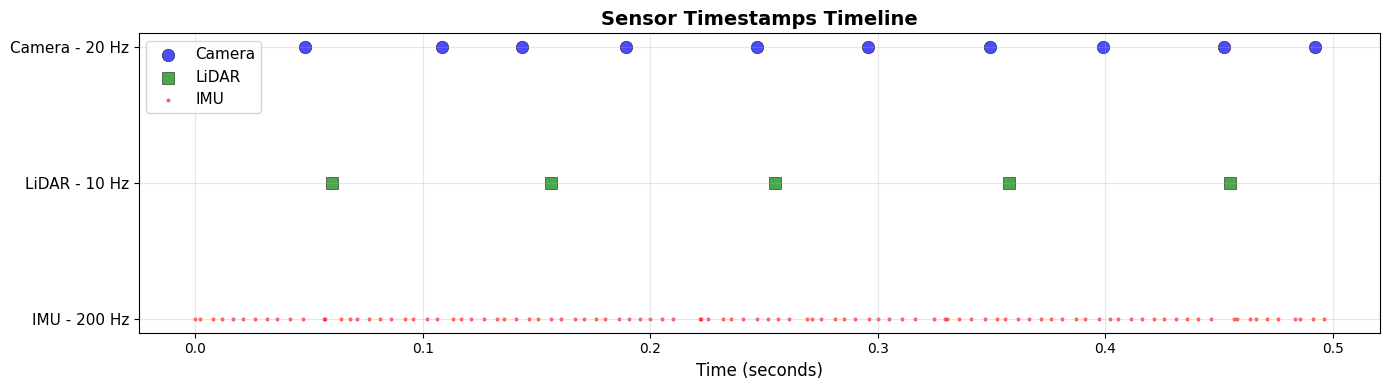

In [8]:
# Sensor Timestamps Timeline Visualization

def plot_sensor_timestamps(camera_data, lidar_data, imu_data):
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    
    camera_times = [f['timestamp_sec'] for f in camera_data]
    lidar_times = [s['timestamp_sec'] for s in lidar_data]
    imu_times = [m['timestamp_sec'] for m in imu_data]
    
    t_offset = min(camera_times[0], lidar_times[0], imu_times[0])
    
    camera_times_rel = [(t - t_offset) for t in camera_times]
    lidar_times_rel = [(t - t_offset) for t in lidar_times]
    imu_times_rel = [(t - t_offset) for t in imu_times]
    
    ax.scatter(camera_times_rel, [2]*len(camera_times_rel), 
              marker='o', s=80, color='blue', label='Camera', alpha=0.7, edgecolors='black', linewidth=0.5)
    ax.scatter(lidar_times_rel, [1]*len(lidar_times_rel), 
              marker='s', s=80, color='green', label='LiDAR', alpha=0.7, edgecolors='black', linewidth=0.5)
    ax.scatter(imu_times_rel, [0]*len(imu_times_rel), 
              marker='.', s=15, color='red', label='IMU', alpha=0.5)
    
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['IMU - 200 Hz', 'LiDAR - 10 Hz', 'Camera - 20 Hz'], fontsize=11)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_title('Sensor Timestamps Timeline', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_sensor_timestamps(
    camera_frames,
    lidar_scans,
    imu_measurements
)

In [ ]:
# Run Preintegration on All Frames

integrator = IMUPreintegrator(max_time_window=0.2, verbose=False)

camera_times = np.array([f['timestamp_sec'] for f in camera_frames])
lidar_times = np.array([s['timestamp_sec'] for s in lidar_scans])
imu_times = np.array([m['timestamp_sec'] for m in imu_measurements])

preintegration_results = []

num_frames = len(camera_frames)
print(f"Preintegrating {num_frames} frames...")

for i in range(num_frames):
    t_camera = camera_frames[i]['timestamp_sec']
    
    closest_lidar_idx = np.argmin(np.abs(lidar_times - t_camera))
    t_lidar = lidar_scans[closest_lidar_idx]['timestamp_sec']
    
    imu_mask = (imu_times >= min(t_camera, t_lidar)) & (imu_times <= max(t_camera, t_lidar))
    imu_indices = np.where(imu_mask)[0]
    imu_between = [imu_measurements[idx] for idx in imu_indices]
    
    if len(imu_between) >= 2:
        result = integrator.preintegrate(
            imu_data=imu_between,
            t_start=min(t_camera, t_lidar),
            t_end=max(t_camera, t_lidar)
        )
        preintegration_results.append(result)
     
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{num_frames} frames")

print(f"Successfully preintegrated {len(preintegration_results)} camera-lidar pairs")

Preintegrating 10 frames...
Successfully preintegrated 9 camera-lidar pairs


In [10]:
# Cell: Check Available Data First

print(f"Available camera frames: {len(camera_frames)}")
print(f"Available LiDAR scans: {len(lidar_scans)}")
print(f"Available IMU measurements: {len(imu_measurements)}")

if len(camera_frames) > 0:
    print(f"\nCamera time range: {camera_frames[0]['timestamp_sec']:.3f} to {camera_frames[-1]['timestamp_sec']:.3f}")
if len(lidar_scans) > 0:
    print(f"LiDAR time range: {lidar_scans[0]['timestamp_sec']:.3f} to {lidar_scans[-1]['timestamp_sec']:.3f}")
if len(imu_measurements) > 0:
    print(f"IMU time range: {imu_measurements[0]['timestamp_sec']:.3f} to {imu_measurements[-1]['timestamp_sec']:.3f}")

Available camera frames: 10
Available LiDAR scans: 5
Available IMU measurements: 101

Camera time range: 1763574244.052 to 1763574244.496
LiDAR time range: 1763574244.064 to 1763574244.459
IMU time range: 1763574244.004 to 1763574244.500


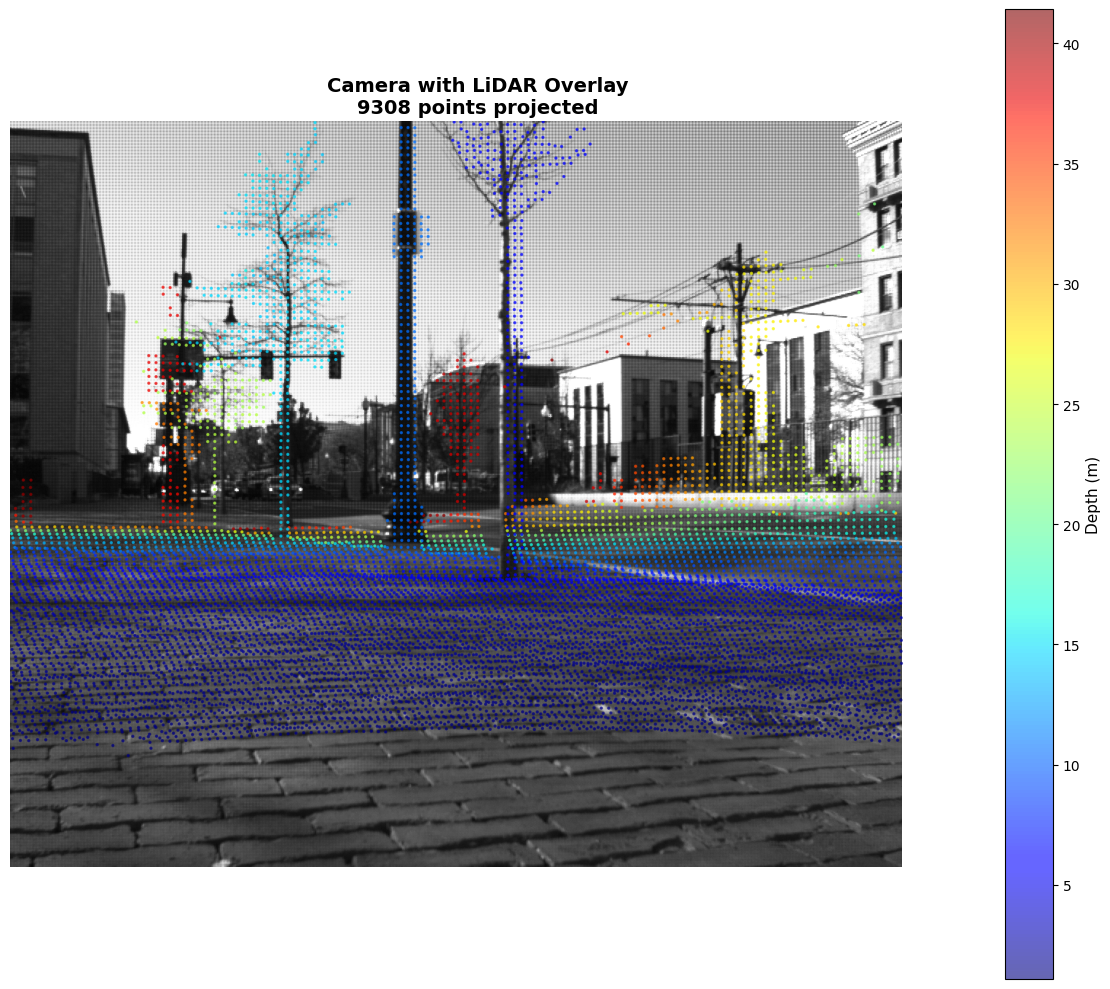

In [11]:
# Camera-LiDAR Overlay

# inverse Lidar -> cam
T_lidar_cam = np.linalg.inv(calib.T_cam_lidar) 

# Get data
frame_idx = 0
image = camera_frames[frame_idx]['image']
points_lidar = lidar_scans[frame_idx]['points']

# Transform LiDAR points to Camera frame
points_hom = np.hstack([points_lidar, np.ones((len(points_lidar), 1))])
points_cam = (T_lidar_cam @ points_hom.T).T

# Filter points in front of camera (Z > 0)
mask_front = points_cam[:, 2] > 0
points_cam = points_cam[mask_front]

# Project to image plane
pixels_h = (calib.camera_matrix @ points_cam[:, :3].T).T
pixels = pixels_h[:, :2] / points_cam[:, 2:3]

# Filter to image bounds
h, w = image.shape[:2]
mask_bounds = (pixels[:, 0] >= 0) & (pixels[:, 0] < w) & \
              (pixels[:, 1] >= 0) & (pixels[:, 1] < h)
pixels = pixels[mask_bounds]
points_cam_valid = points_cam[mask_bounds]

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Color points by depth
depths = points_cam_valid[:, 2]
scatter = ax.scatter(pixels[:, 0], pixels[:, 1], 
                    c=depths, cmap='jet', s=2, alpha=0.6)

ax.set_title(f'Camera with LiDAR Overlay\n{len(pixels)} points projected', 
            fontsize=14, fontweight='bold')
ax.axis('off')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Depth (m)', fontsize=11)

plt.tight_layout()
plt.show()